In [1]:
import pandas as pd
df = pd.read_csv("../data/sentiment_results.csv")

__Pozitif/Negatif/Nötr dağılım grafiklerinin oluşturulması__

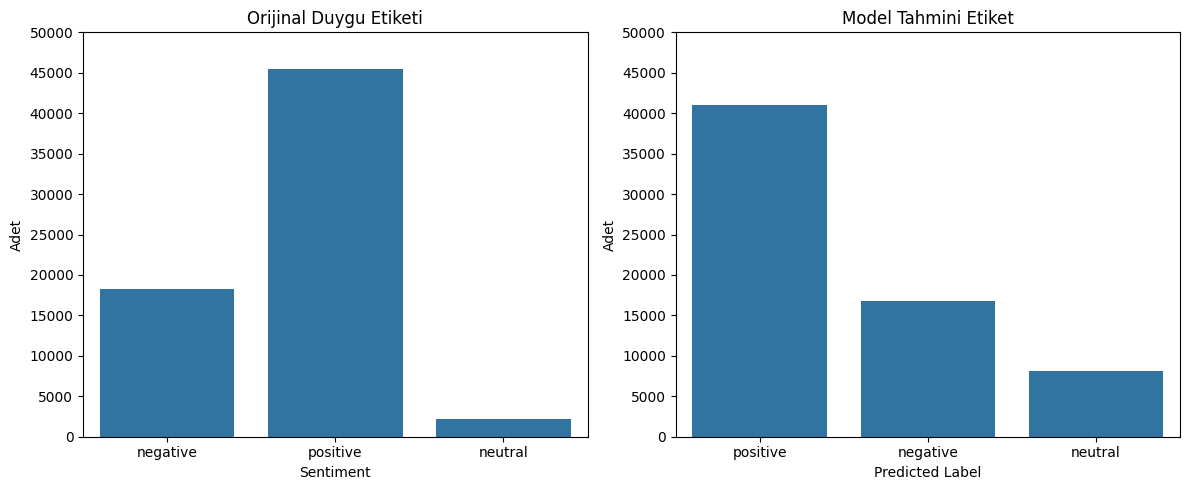

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(12, 5))

yticks = np.arange(0, 50001, 5000) 

plt.subplot(1, 2, 1)
sns.countplot(x='sentiment', data=df)
plt.title("Orijinal Duygu Etiketi")
plt.ylim(0, 50000)
plt.yticks(yticks)
plt.xlabel("Sentiment")
plt.ylabel("Adet")

plt.subplot(1, 2, 2)
sns.countplot(x='normalized_pred_label', data=df)
plt.title("Model Tahmini Etiket")
plt.ylim(0, 50000)
plt.yticks(yticks)
plt.xlabel("Predicted Label")
plt.ylabel("Adet")

plt.tight_layout()
plt.show()


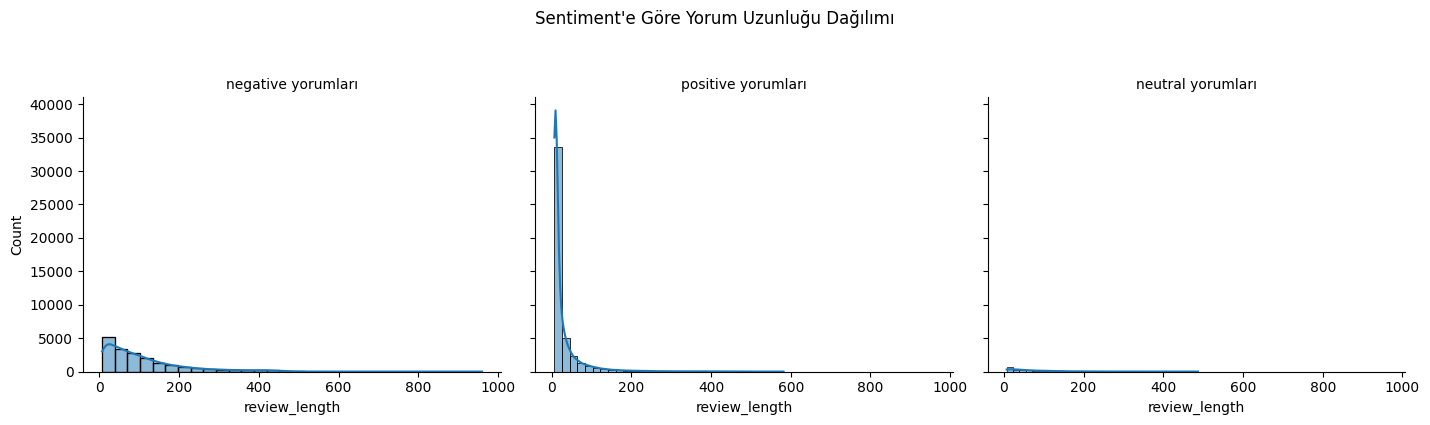

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(df, col='sentiment', height=4, aspect=1.2)
g.map(sns.histplot, 'review_length', bins=30, kde=True)
g.set_titles(col_template="{col_name} yorumları")
plt.suptitle("Sentiment'e Göre Yorum Uzunluğu Dağılımı", y=1.05)
plt.tight_layout()
plt.show()


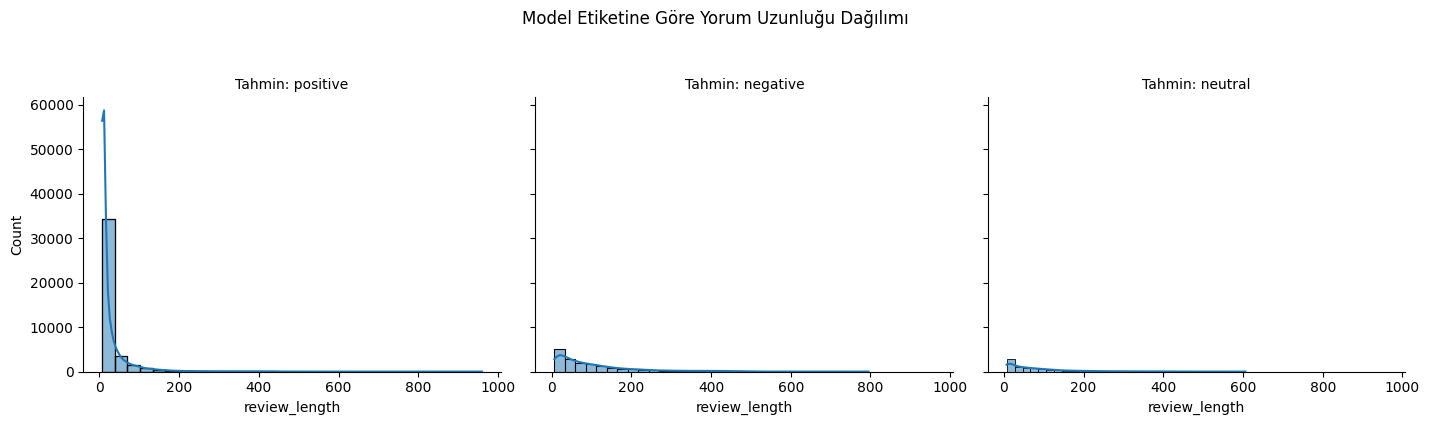

In [4]:
g = sns.FacetGrid(df, col='normalized_pred_label', height=4, aspect=1.2)
g.map(sns.histplot, 'review_length', bins=30, kde=True)
g.set_titles(col_template="Tahmin: {col_name}")
plt.suptitle("Model Etiketine Göre Yorum Uzunluğu Dağılımı", y=1.05)
plt.tight_layout()
plt.show()

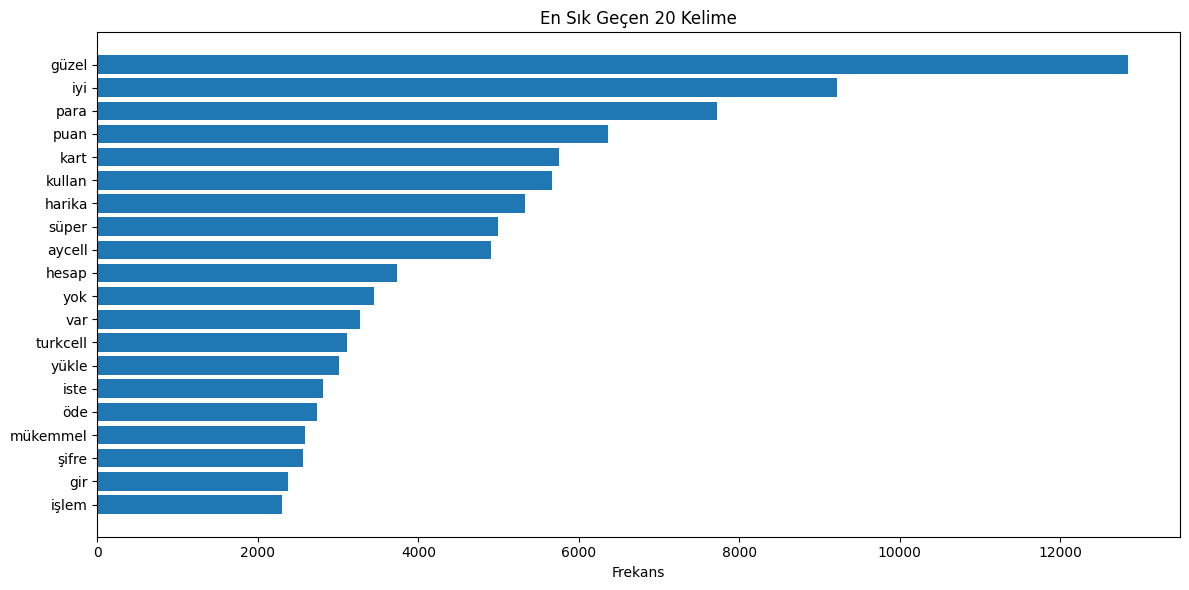

In [5]:
from collections import Counter
import matplotlib.pyplot as plt
import ast

all_words = []
for lem in df['lemmas']:
    words = ast.literal_eval(lem)
    all_words.extend([w.lower().strip() for w in words if w.isalpha()])  

word_freq = Counter(all_words)

top_words = word_freq.most_common(20)

words, counts = zip(*top_words)

plt.figure(figsize=(12, 6))
plt.barh(words[::-1], counts[::-1])  
plt.xlabel("Frekans")
plt.title("En Sık Geçen 20 Kelime")
plt.tight_layout()
plt.show()


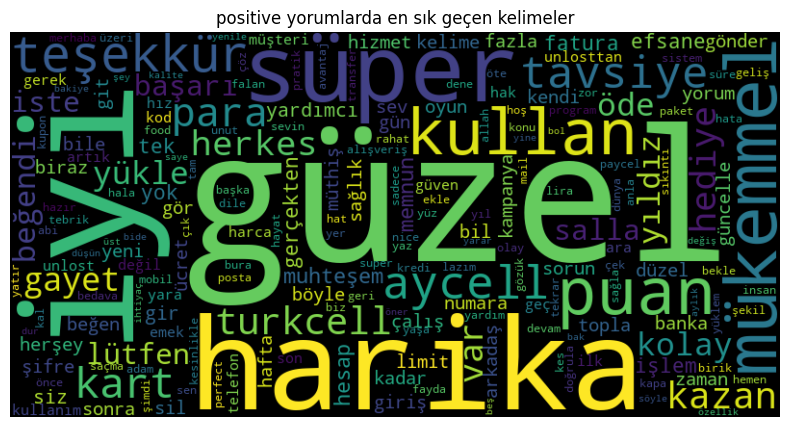

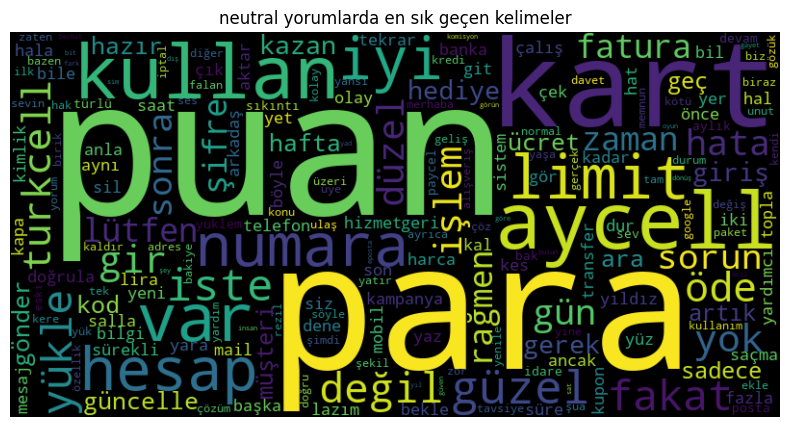

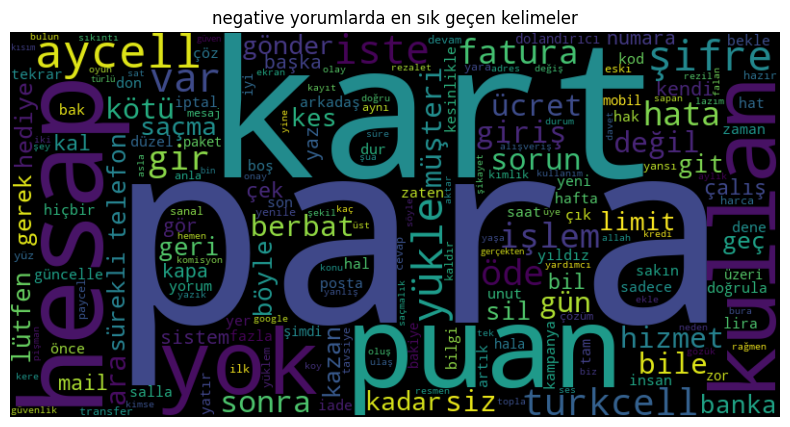

In [6]:
from wordcloud import WordCloud
import ast

for label in ['positive', 'neutral', 'negative']:
    lemmas = df[df['normalized_pred_label'] == label]['lemmas']
    
    all_words = []
    for lem in lemmas:
        try:
            words = ast.literal_eval(lem) if isinstance(lem, str) else lem
            words = [w.lower().strip() for w in words if w.isalpha()]
            all_words.extend(words)
        except:
            continue
    
    text = " ".join(all_words)
    
    wc = WordCloud(width=800, height=400, collocations=False).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{label} yorumlarda en sık geçen kelimeler')
    plt.show()


In [7]:
df["lemmas"]

0                                         ['sakin', 'gir']
1        ['arkadaş', 'davet', 'buton', 'çalış', 'progra...
2                                           ['ses', 'kod']
3        ['geçici', 'ilan', 'bilgi', 'ulaş', 'sorun', '...
4        ['onayla', 'telefon', 'nbc', 'özellik', 'zorun...
                               ...                        
65959    ['iyi', 'ancak', 'günlük', 'giriş', 'kredi', '...
65960    ['arkadaş', 'türk', 'sel', 'bayi', 'mail', 'ad...
65961    ['arena', 'valon', 'oyun', 'nakit', 'çek', 'oy...
65962                       ['arayüz', 'gerçekten', 'iyi']
65963    ['anne', 'biz', 'dolandiriyosunuz', 'polis', '...
Name: lemmas, Length: 65964, dtype: object

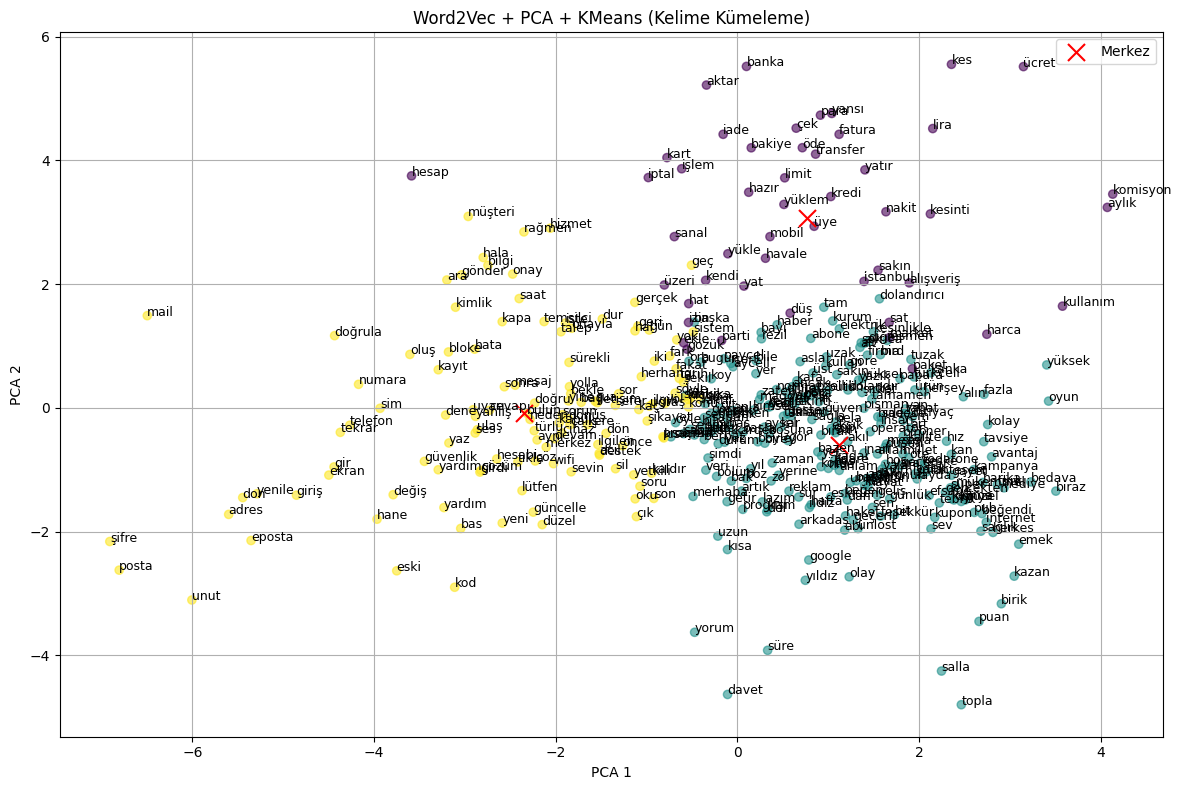

In [8]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

tokenized_docs = df["lemmas"].dropna().apply(ast.literal_eval).tolist()

model = Word2Vec(sentences=tokenized_docs, vector_size=50, window=5, min_count=2, sg=0)
word_vectors = model.wv

words = list(word_vectors.index_to_key)[:400]
vectors = word_vectors[words]

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(vectors)

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(vectors)
centers = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(12, 8))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=150, label='Merkez')

for i, word in enumerate(words):
    plt.text(reduced_vectors[i, 0], reduced_vectors[i, 1], word, fontsize=9)

plt.title("Word2Vec + PCA + KMeans (Kelime Kümeleme)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


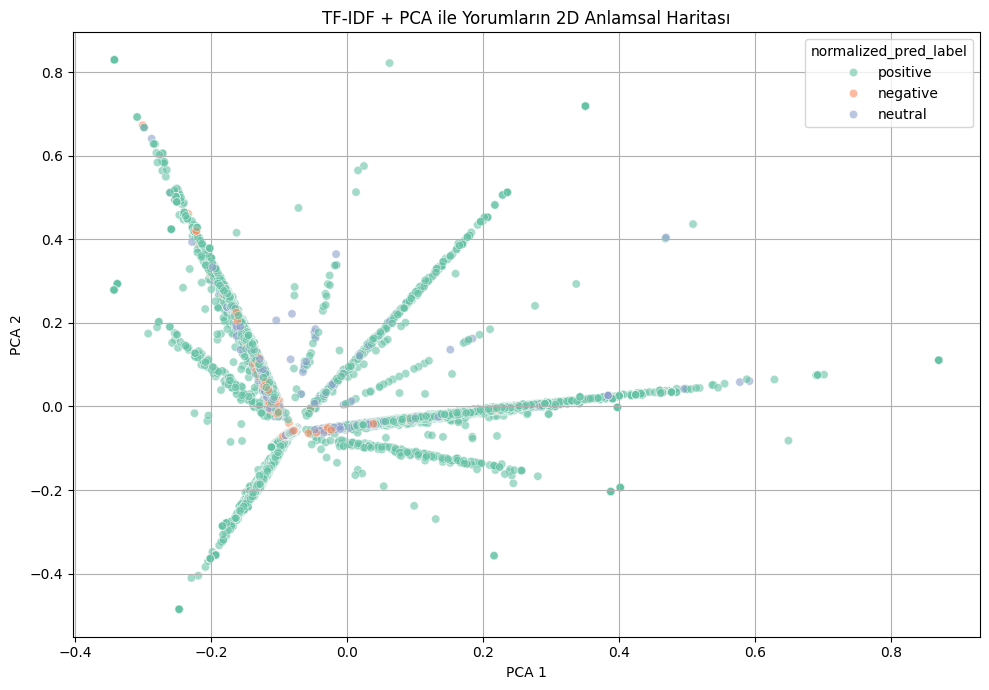

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Temizlenmiş yorum metinlerini birleştir
texts = df['lemmas']

# 2. TF-IDF vektörleri
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(texts)

# 3. PCA ile 2 boyuta indir
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

# 4. Sonuçları DataFrame'e ekle
df['pca1'] = X_pca[:, 0]
df['pca2'] = X_pca[:, 1]

# 5. Scatter plot: yorumlar, sentiment rengine göre
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='pca1', y='pca2',
                hue='normalized_pred_label',  # ya da 'sentiment' kullanabilirsin
                palette='Set2', alpha=0.6)
plt.title('TF-IDF + PCA ile Yorumların 2D Anlamsal Haritası')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.tight_layout()
plt.show()


<Axes: xlabel='Tarih'>

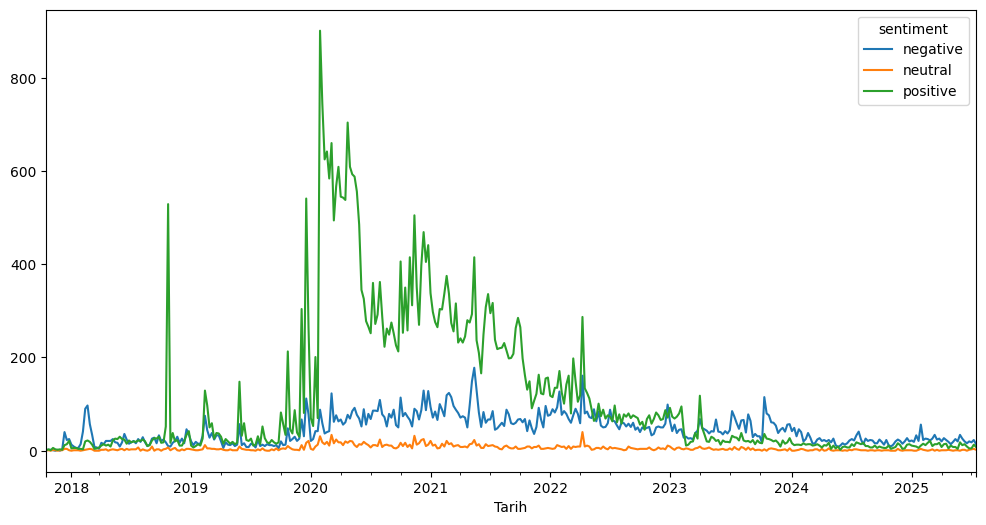

In [10]:
df_temp = df.copy()
df_temp['Tarih'] = pd.to_datetime(df_temp['Tarih'])
df_temp.set_index('Tarih', inplace=True)

df_temp.resample('W')['sentiment'].value_counts().unstack().fillna(0).plot(figsize=(12, 6))


<Axes: xlabel='Tarih'>

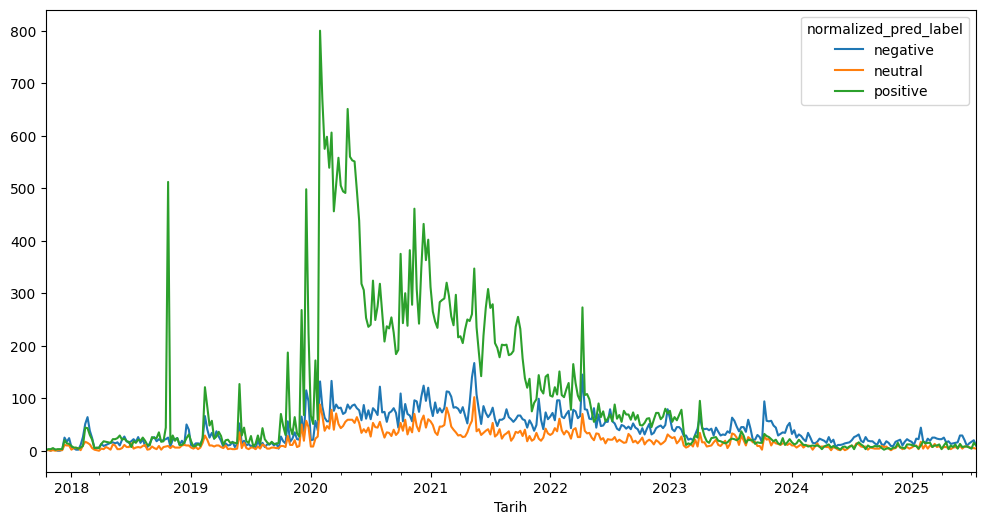

In [11]:
df_temp = df.copy()
df_temp['Tarih'] = pd.to_datetime(df_temp['Tarih'])
df_temp.set_index('Tarih', inplace=True)

df_temp.resample('W')['normalized_pred_label'].value_counts().unstack().fillna(0).plot(figsize=(12, 6))


<Figure size 600x600 with 0 Axes>

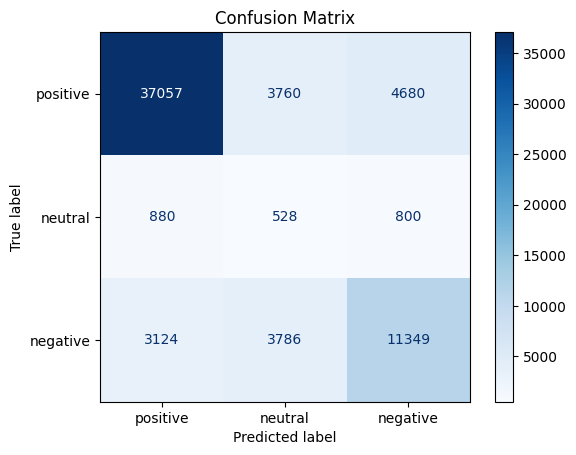

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = df['sentiment']
y_pred = df['normalized_pred_label']

cm = confusion_matrix(y_true, y_pred, labels=["positive", "neutral", "negative"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["positive", "neutral", "negative"])

plt.figure(figsize=(6,6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


<Figure size 1000x600 with 0 Axes>

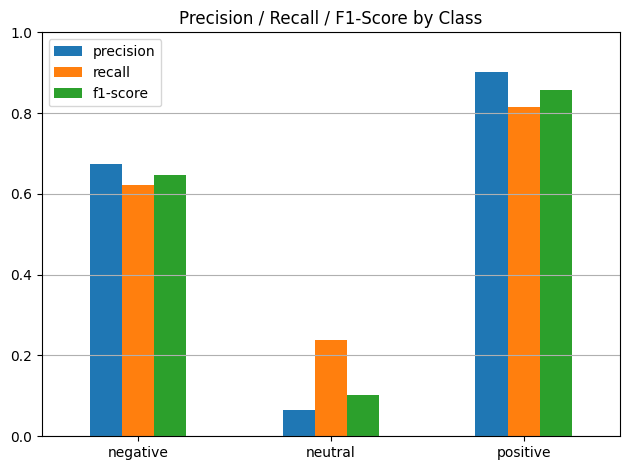

In [13]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

report = classification_report(y_true, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().iloc[:3]  # sadece sınıflar

plt.figure(figsize=(10,6))
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar')
plt.title("Precision / Recall / F1-Score by Class")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [14]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_true, y_pred)
print(f"Doğruluk (Accuracy): {acc:.2%}")


Doğruluk (Accuracy): 74.18%


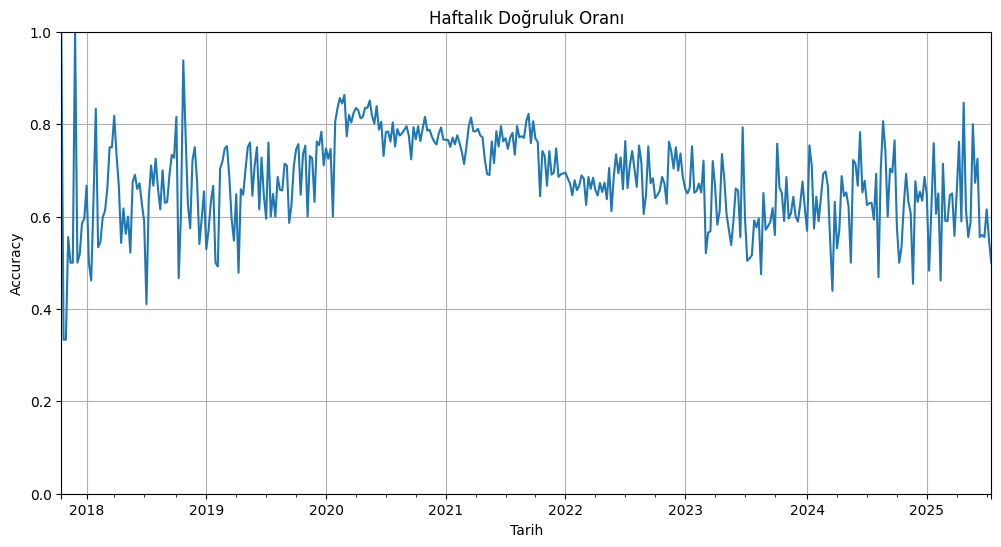

In [15]:
df['correct'] = df['sentiment'] == df['normalized_pred_label']
df['Tarih'] = pd.to_datetime(df['Tarih'])
weekly_acc = df.set_index('Tarih').resample('W')['correct'].mean()

weekly_acc.plot(figsize=(12, 6))
plt.title("Haftalık Doğruluk Oranı")
plt.ylabel("Accuracy")
plt.xlabel("Tarih")
plt.grid(True)
plt.ylim(0, 1)
plt.show()


In [16]:
df

,lemmas,sentiment,review_length,normalized_pred_label,Tarih,pca1,pca2,correct
0,"['sakin', 'gir']",negative,16,positive,2025-07-19 22:54:03,-0.081434,-0.060470,False
1,"['arkadaş', 'davet', 'buton', 'çalış', 'progra...",positive,60,negative,2025-07-19 15:19:42,-0.080034,-0.059049,False
2,"['ses', 'kod']",negative,14,neutral,2025-07-19 09:00:43,-0.080343,-0.059290,False
3,"['geçici', 'ilan', 'bilgi', 'ulaş', 'sorun', '...",positive,51,negative,2025-07-19 06:27:28,-0.080743,-0.059561,False
4,"['onayla', 'telefon', 'nbc', 'özellik', 'zorun...",negative,176,negative,2025-07-18 14:50:20,-0.086621,-0.064982,True
...,...,...,...,...,...,...,...,...
65959,"['iyi', 'ancak', 'günlük', 'giriş', 'kredi', '...",positive,51,neutral,2017-10-25 19:51:01,-0.198128,0.333275,False
65960,"['arkadaş', 'türk', 'sel', 'bayi', 'mail', 'ad...",negative,84,positive,2017-10-25 15:07:58,-0.081857,-0.060806,False
65961,"['arena', 'valon', 'oyun', 'nakit', 'çek', 'oy...",neutral,68,neutral,2017-10-21 10:55:40,-0.080876,-0.059699,True
65962,"['arayüz', 'gerçekten', 'iyi']",positive,30,positive,2017-10-18 19:05:47,-0.160402,0.217469,True


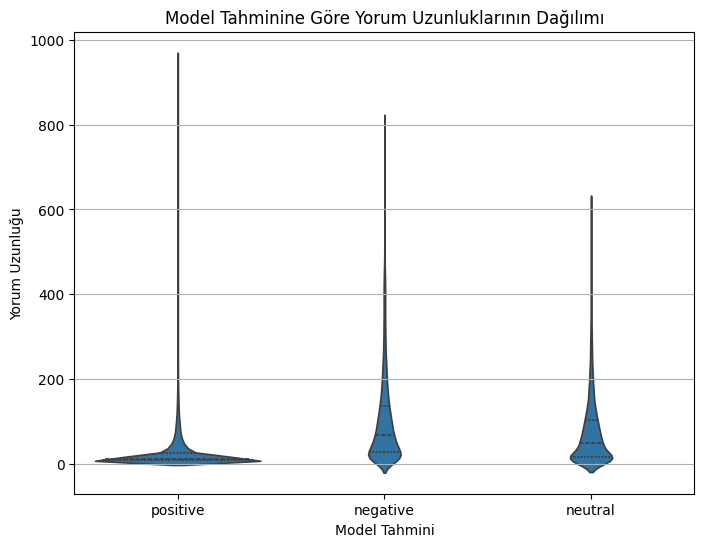

In [17]:
plt.figure(figsize=(8, 6))
sns.violinplot(x='normalized_pred_label', y='review_length', data=df, inner='quartile')
plt.title("Model Tahminine Göre Yorum Uzunluklarının Dağılımı")
plt.xlabel("Model Tahmini")
plt.ylabel("Yorum Uzunluğu")
plt.grid(axis='y')
plt.show()


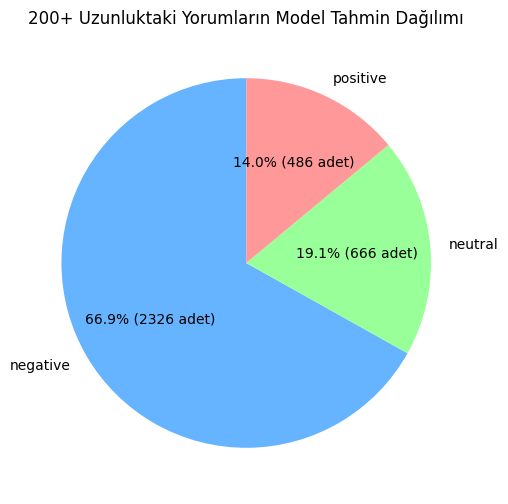

In [18]:
import matplotlib.pyplot as plt

df_200plus = df[df['review_length'] > 200]

counts = df_200plus['normalized_pred_label'].value_counts()
labels = counts.index
sizes = counts.values

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{pct:.1f}% ({val} adet)'
    return my_autopct

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct=make_autopct(sizes), startangle=90,
        colors=['#66b3ff', '#99ff99', '#ff9999'])
plt.title("200+ Uzunluktaki Yorumların Model Tahmin Dağılımı")
plt.ylabel("")
plt.show()


__VERSION UPDATELERINE GORE ANALİZ__

In [19]:
updates_df =  pd.read_csv("paycell_update_history_app_store_labeled 2.csv")

In [20]:
updates_df.head()

,Date,Version,Update,big_updates
0,04-07-2025,9.3.1,Geleceğin finansal teknolojisi Paycell'i geliş...,0
1,25-06-2025,9.3.0,Geleceğin finansal teknolojisi Paycell’i geliş...,1
2,2-06-2025,9.2.1,Geleceğin finansal teknolojisi Paycell’i geliş...,0
3,29-05-2025,9.2.0,Geleceğin finansal teknolojisi Paycell’i geliş...,1
4,9-05-2025,9.1.0,Geleceğin finansal teknolojisi Paycell’i geliş...,0


In [21]:
updates_df['Date'] = pd.to_datetime(updates_df['Date'], dayfirst=True)
update_points = updates_df[updates_df['big_updates'] == 1].sort_values('Date').reset_index(drop=True)

df['Tarih'] = pd.to_datetime(df['Tarih'], format="%Y-%m-%d %H.%M.%S")

def assign_update_label(row):
    for i in range(len(update_points) - 1):
        if update_points.loc[i, 'Date'] <= row['Tarih'] < update_points.loc[i+1, 'Date']:
            return f"{update_points.loc[i, 'Version']} - {update_points.loc[i+1, 'Version']}"
    if row['Tarih'] >= update_points.loc[len(update_points) - 1, 'Date']:
        return f"{update_points.loc[len(update_points) - 1, 'Version']} - sonrası"
    return None

df['update_range'] = df.apply(assign_update_label, axis=1)

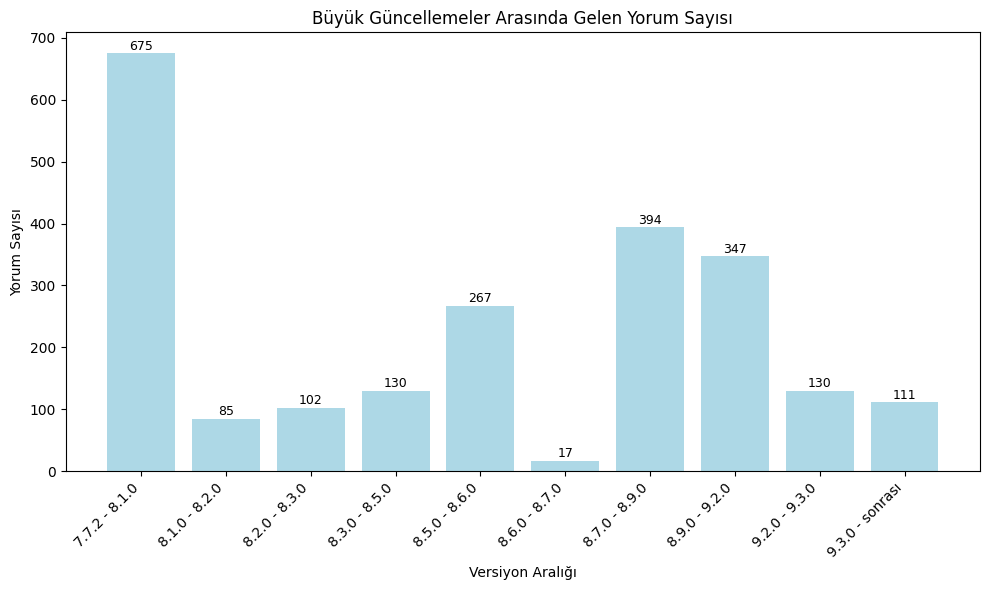

In [22]:
import matplotlib.pyplot as plt

count_by_update = df['update_range'].value_counts().sort_index()

labels = count_by_update.index.tolist()
values = count_by_update.values.tolist()

plt.figure(figsize=(10,6))
bars = plt.bar(labels, values, color='lightblue')

plt.title("Büyük Güncellemeler Arasında Gelen Yorum Sayısı")
plt.xlabel("Versiyon Aralığı")
plt.ylabel("Yorum Sayısı")
plt.xticks(rotation=45, ha='right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, str(yval), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [23]:
average_results = []

for i in range(len(update_points) - 1):
    start = update_points.loc[i, 'Date']
    end = update_points.loc[i + 1, 'Date']
    label = f"{update_points.loc[i, 'Version']} - {update_points.loc[i+1, 'Version']}"

    mask = (df['Tarih'] >= start) & (df['Tarih'] < end)
    comment_count = mask.sum()
    day_diff = (end - start).days

    daily_avg = comment_count / day_diff if day_diff > 0 else 0

    average_results.append((label, daily_avg))

start = update_points.loc[len(update_points)-1, 'Date']
end = df['Tarih'].max()
label = f"{update_points.loc[len(update_points)-1, 'Version']} - sonrası"
mask = (df['Tarih'] >= start)
comment_count = mask.sum()
day_diff = (end - start).days
daily_avg = comment_count / day_diff if day_diff > 0 else 0
average_results.append((label, daily_avg))

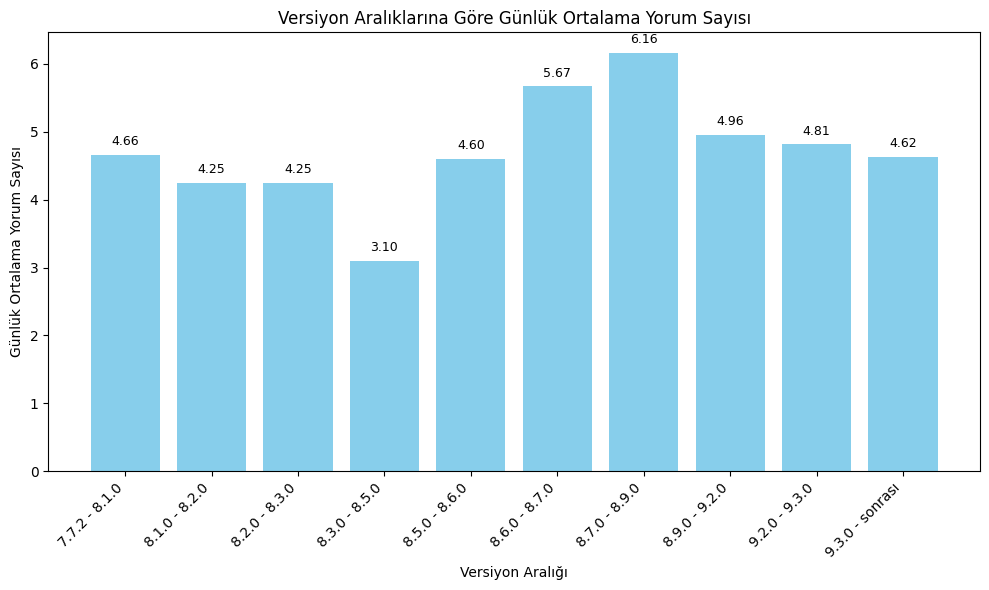

In [24]:
import matplotlib.pyplot as plt

labels = [x[0] for x in average_results]
values = [x[1] for x in average_results]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color='skyblue')

plt.xticks(rotation=45, ha='right')
plt.ylabel("Günlük Ortalama Yorum Sayısı")
plt.xlabel("Versiyon Aralığı")
plt.title("Versiyon Aralıklarına Göre Günlük Ortalama Yorum Sayısı")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f"{yval:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

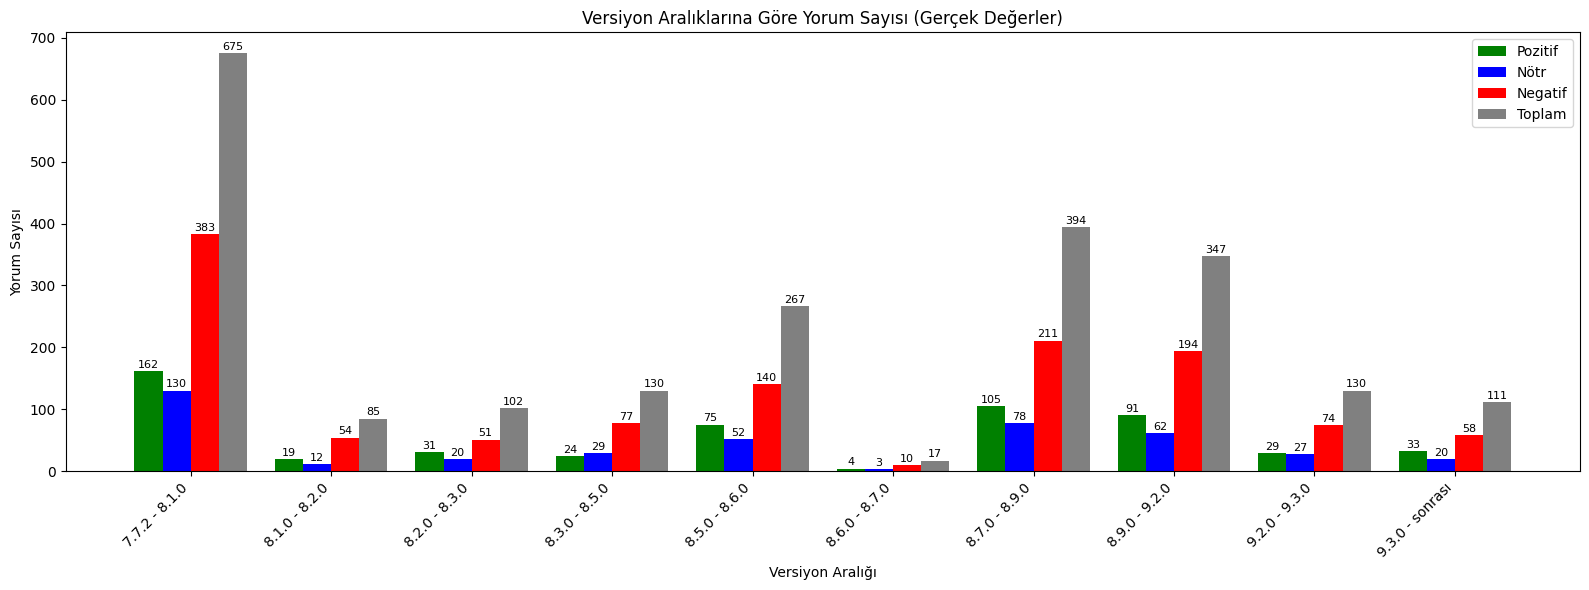

In [43]:
count_total    = df['update_range'].value_counts().sort_index()
count_positive = df[df['normalized_pred_label'] == 'positive']['update_range'].value_counts().sort_index()
count_neutral  = df[df['normalized_pred_label'] == 'neutral']['update_range'].value_counts().sort_index()
count_negative = df[df['normalized_pred_label'] == 'negative']['update_range'].value_counts().sort_index()

labels   = count_total.index.tolist()
total    = count_total.values.tolist()
positive = count_positive.reindex(labels, fill_value=0).values.tolist()
neutral  = count_neutral.reindex(labels, fill_value=0).values.tolist()
negative = count_negative.reindex(labels, fill_value=0).values.tolist()

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(labels))
width = 0.20

plt.figure(figsize=(16,6))

bars_positive = plt.bar(x - 1.5*width, positive, width=width, label='Pozitif', color='green')
bars_neutral  = plt.bar(x - 0.5*width, neutral,  width=width, label='Nötr',    color='blue')
bars_negative = plt.bar(x + 0.5*width, negative, width=width, label='Negatif', color='red')
bars_total    = plt.bar(x + 1.5*width, total,    width=width, label='Toplam',  color='gray')

for bars in [bars_positive, bars_neutral, bars_negative, bars_total]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 2, str(int(yval)),
                 ha='center', va='bottom', fontsize=8)

plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel("Yorum Sayısı")
plt.xlabel("Versiyon Aralığı")
plt.title("Versiyon Aralıklarına Göre Yorum Sayısı (Gerçek Değerler)")
plt.legend()
plt.tight_layout()
plt.show()


In [38]:
average_results = []

for i in range(len(update_points) - 1):
    start = update_points.loc[i, 'Date']
    end = update_points.loc[i + 1, 'Date']
    label = f"{update_points.loc[i, 'Version']} - {update_points.loc[i+1, 'Version']}"
    day_count = (end - start).days

    total_count = df[(df['Tarih'] >= start) & (df['Tarih'] < end)].shape[0]
    pos_count = df[(df['Tarih'] >= start) & (df['Tarih'] < end) & (df['normalized_pred_label'] == 'positive')].shape[0]
    neg_count = df[(df['Tarih'] >= start) & (df['Tarih'] < end) & (df['normalized_pred_label'] == 'negative')].shape[0]
    neu_count = df[(df['Tarih'] >= start) & (df['Tarih'] < end) & (df['normalized_pred_label'] == 'neutral')].shape[0]

    average_results.append({
        'label': label,
        'total': total_count / day_count if day_count > 0 else 0,
        'positive': pos_count / day_count if day_count > 0 else 0,
        'negative': neg_count / day_count if day_count > 0 else 0,
        'neutral': neu_count / day_count if day_count > 0 else 0
    })

# Son güncellemeden sonrası
start = update_points.loc[len(update_points) - 1, 'Date']
end = df['Tarih'].max()
label = f"{update_points.loc[len(update_points)-1, 'Version']} - sonrası"
day_count = (end - start).days

total_count = df[(df['Tarih'] >= start)].shape[0]
pos_count = df[(df['Tarih'] >= start) & (df['normalized_pred_label'] == 'positive')].shape[0]
neg_count = df[(df['Tarih'] >= start) & (df['normalized_pred_label'] == 'negative')].shape[0]
neu_count = df[(df['Tarih'] >= start) & (df['normalized_pred_label'] == 'neutral')].shape[0]

average_results.append({
    'label': label,
    'total': total_count / day_count if day_count > 0 else 0,
    'positive': pos_count / day_count if day_count > 0 else 0,
    'negative': neg_count / day_count if day_count > 0 else 0,
    'neutral': neu_count / day_count if day_count > 0 else 0
})


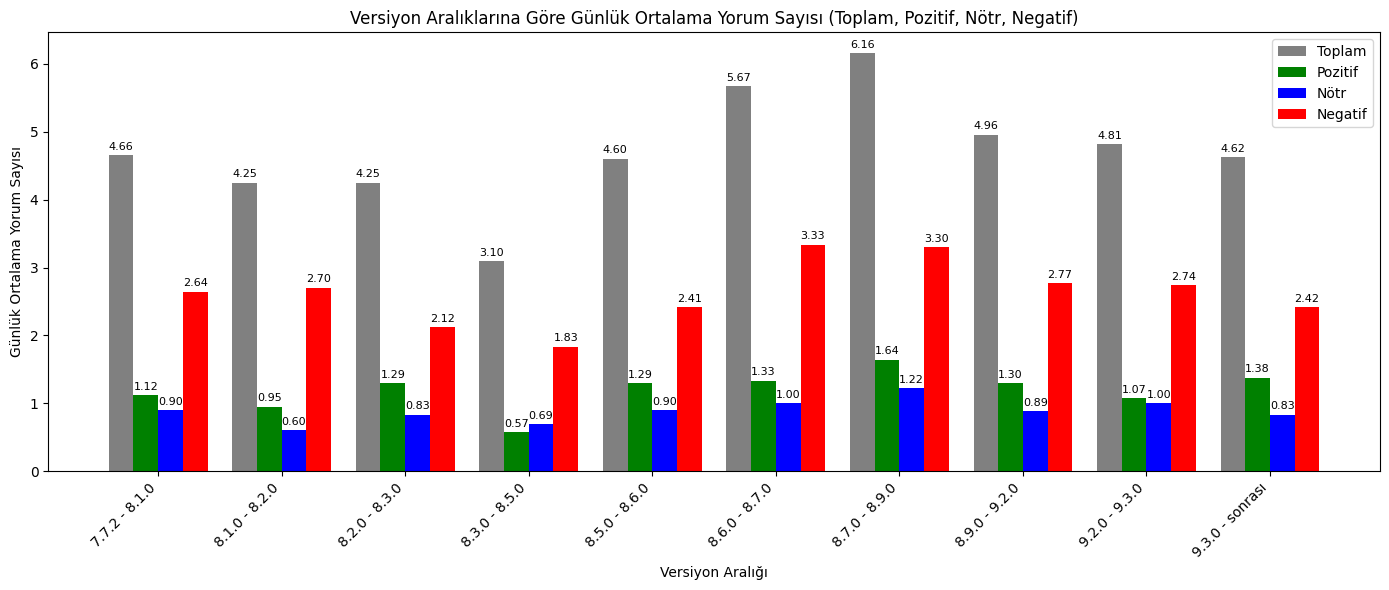

In [39]:
import matplotlib.pyplot as plt
import numpy as np

labels = [x['label'] for x in average_results]
totals = [x['total'] for x in average_results]
positives = [x['positive'] for x in average_results]
negatives = [x['negative'] for x in average_results]
neutrals  = [x['neutral'] for x in average_results]

x = np.arange(len(labels))
width = 0.20

plt.figure(figsize=(14,6))

bars_total    = plt.bar(x - 1.5*width, totals,   width=width, label='Toplam',  color='gray')
bars_positive = plt.bar(x - 0.5*width, positives,width=width, label='Pozitif', color='green')
bars_neutral  = plt.bar(x + 0.5*width, neutrals, width=width, label='Nötr',    color='blue')
bars_negative = plt.bar(x + 1.5*width, negatives,width=width, label='Negatif', color='red')

plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel("Günlük Ortalama Yorum Sayısı")
plt.xlabel("Versiyon Aralığı")
plt.title("Versiyon Aralıklarına Göre Günlük Ortalama Yorum Sayısı (Toplam, Pozitif, Nötr, Negatif)")
plt.legend()

for bars in [bars_total, bars_positive, bars_neutral, bars_negative]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f"{yval:.2f}",
                 ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [44]:
updates_df['Date'] = pd.to_datetime(updates_df['Date'], dayfirst=True)
df['Tarih'] = pd.to_datetime(df['Tarih'])

negatives_df = df[df['sentiment'] == 'negative']

updates_df = updates_df.sort_values(by='Date').reset_index(drop=True)

results = []
for i in range(len(updates_df)-1):
    version = updates_df.loc[i, 'Version']
    start = updates_df.loc[i, 'Date']
    end = updates_df.loc[i+1, 'Date']
    
    mask = (negatives_df['Tarih'] >= start) & (negatives_df['Tarih'] < end)
    count = negatives_df[mask].shape[0]
    
    results.append({
        'Version': version,
        'start_date': start,
        'end_date': end,
        'negative_review_count': count
    })

last_version = updates_df.iloc[-1]
mask = (negatives_df['Tarih'] >= last_version['Date'])
count = negatives_df[mask].shape[0]
results.append({
    'Version': last_version['Version'],
    'start_date': last_version['Date'],
    'end_date': 'ongoing',
    'negative_review_count': count
})

neg_counts_df = pd.DataFrame(results)
neg_counts_df.head()

,Version,start_date,end_date,negative_review_count
0,5.9.0,2022-08-12,2022-09-19 00:00:00,285
1,6.0.0,2022-09-19,2022-09-23 00:00:00,28
2,6.0.1,2022-09-23,2022-11-22 00:00:00,382
3,6.2.0,2022-11-22,2022-12-22 00:00:00,245
4,6.4.1,2022-12-22,2023-01-25 00:00:00,273


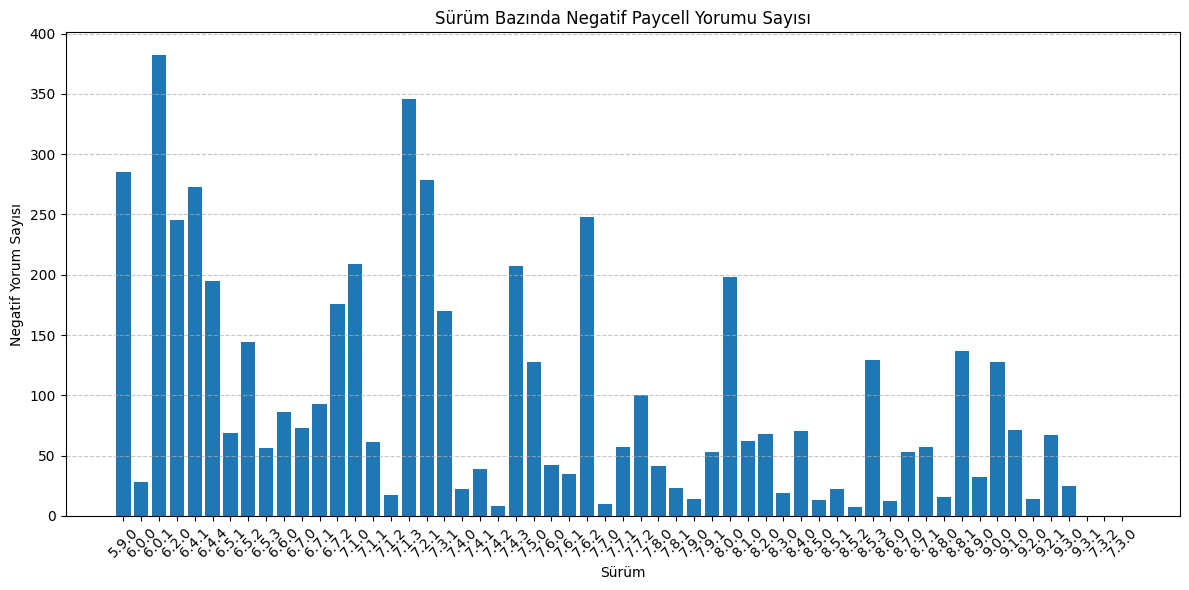

In [45]:
import matplotlib.pyplot as plt

neg_counts_df['Version'] = neg_counts_df['Version'].astype(str)

plt.figure(figsize=(12, 6))
plt.bar(neg_counts_df['Version'], neg_counts_df['negative_review_count'])

plt.xticks(rotation=45)
plt.xlabel("Sürüm")
plt.ylabel("Negatif Yorum Sayısı")
plt.title("Sürüm Bazında Negatif Paycell Yorumu Sayısı")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [46]:
def draw_sentiment_bar_chart(df, sentiment_label, color='blue'):
    
    temp_df = df[df['sentiment'] == sentiment_label].copy()
    temp_df['Tarih'] = pd.to_datetime(temp_df['Tarih'])

    start_date = temp_df['Tarih'].min().to_period('M').to_timestamp()
    end_date = temp_df['Tarih'].max().to_period('M').to_timestamp()
    window_starts = pd.date_range(start=start_date, end=end_date, freq='2MS')

    results = []
    for start in window_starts:
        end = start + pd.DateOffset(months=3)
        mask = (temp_df['Tarih'] >= start) & (temp_df['Tarih'] < end)
        count = temp_df.loc[mask].shape[0]
        label = f"{start.strftime('%m.%y')}-{(end - pd.DateOffset(days=1)).strftime('%m.%y')}"
        results.append({'periyot': label, 'yorum_sayi': count})

    counts = pd.DataFrame(results)
    plt.figure(figsize=(16, 6))
    plt.bar(counts['periyot'], counts['yorum_sayi'], width=0.6, color=color)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Periyot (3 Ay)")
    plt.ylabel("Yorum Sayısı")
    plt.title(f"{sentiment_label.capitalize()} Yorumların 3 Aylık Dağılımı")
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()


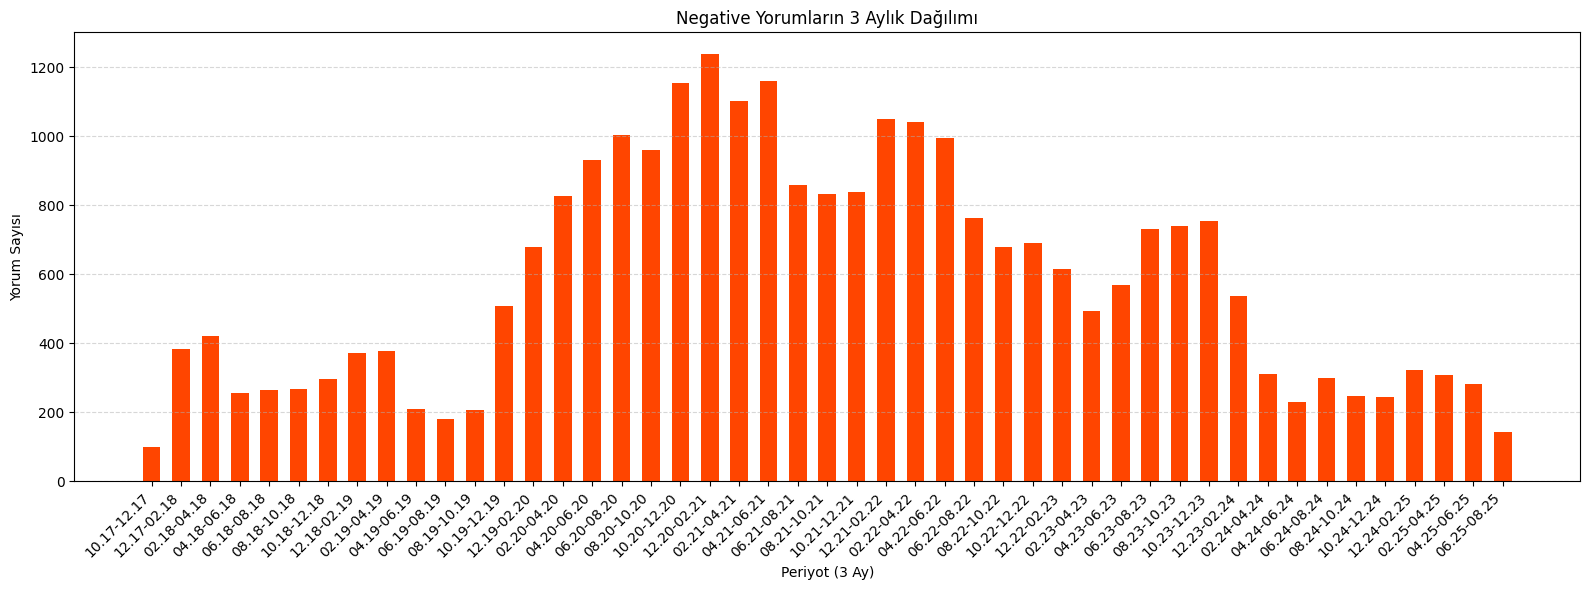

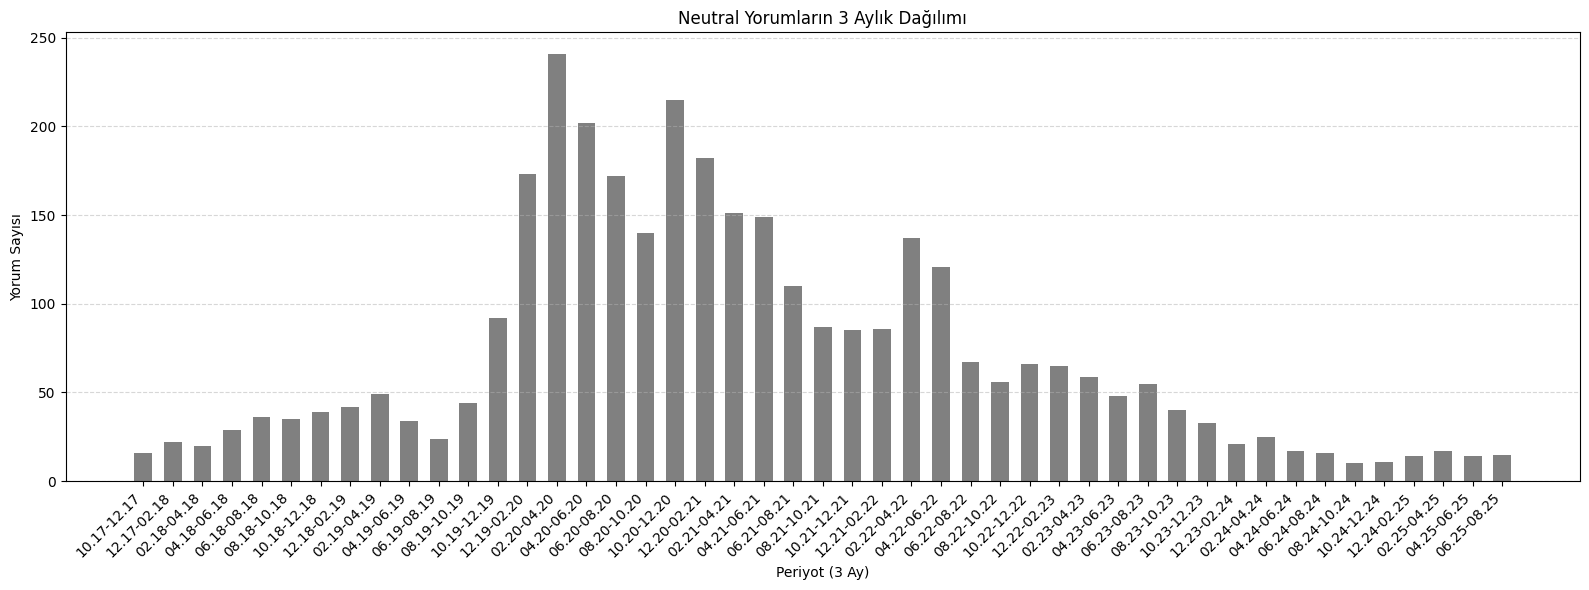

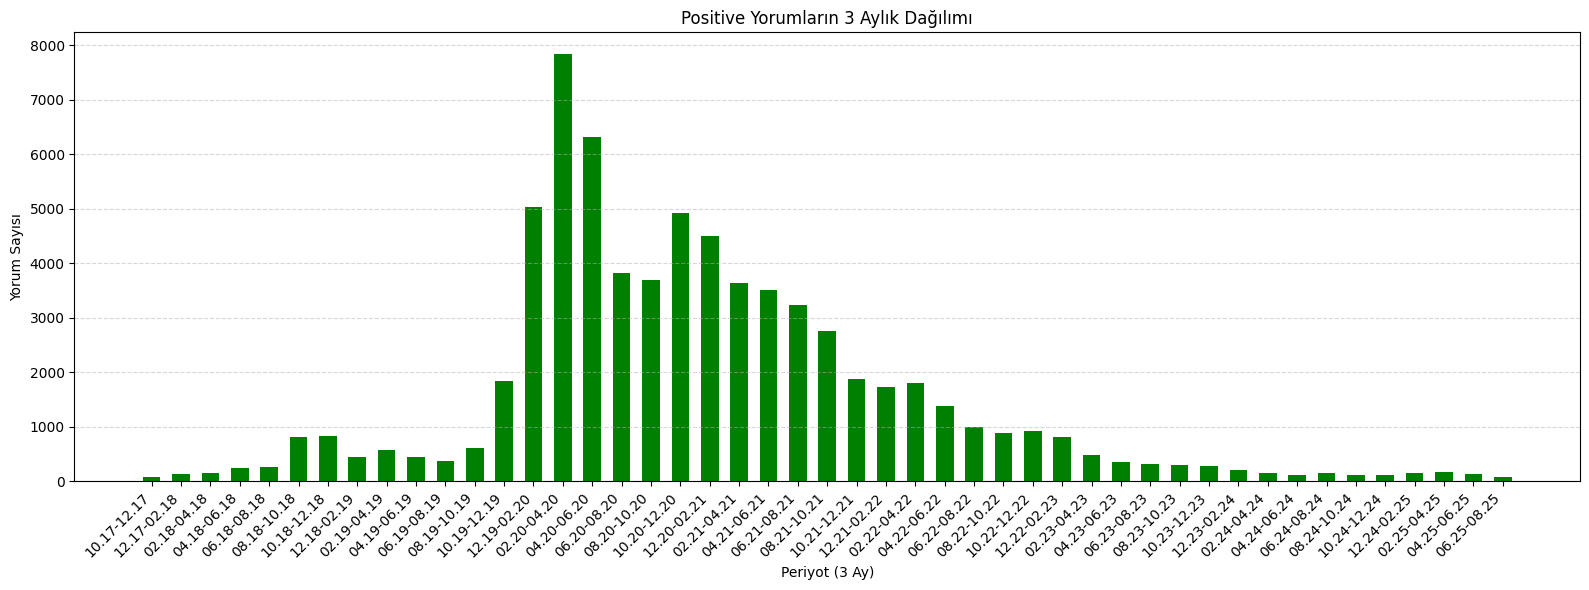

In [47]:
draw_sentiment_bar_chart(df, 'negative', color="orangered")
draw_sentiment_bar_chart(df, 'neutral', color='gray')
draw_sentiment_bar_chart(df, 'positive', color='green')
